In [26]:
import requests
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
import gspread
import logging
import json
import geopandas as gpd
import gc
# logging.basicConfig(filename='waza_scraper.log', format='%(asctime)s %(message)s', filemode='w') 
# logger=logging.getLogger() 
# logger.setLevel(logging.DEBUG)
serviceaccount = "/home/yuanzf/google_drive_personal.json"
gs = gspread.service_account(filename=serviceaccount)

def read_url(url, SHEET_NAME):
    SHEET_ID = url.split("/")[5]
    spreadsheet = gs.open_by_key(SHEET_ID)
    worksheet = spreadsheet.worksheet(SHEET_NAME)
    rows = worksheet.get_all_records()
    df_spread = pd.DataFrame(rows)
    return df_spread, worksheet

In [4]:
url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
SHEETNAME = "select_city_classifier"
city_meta, other_worksheet = read_url(url, SHEETNAME)
city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
city_meta = city_meta[city_meta['GSV Downloaded']>0].reset_index(drop = True)
city_meta['city_lower'] = city_meta['City'].apply(lambda x: x.replace(" ", "").lower())

In [5]:
ROOTFOLDER = "/group/geog_pyloo/08_GSV/data/_raw/waze"
EXPORTFOLDER = "/group/geog_pyloo/08_GSV/data/_curated/waze"
if not os.path.exists(EXPORTFOLDER):
    os.makedirs(EXPORTFOLDER)
files = os.listdir(ROOTFOLDER)
# files

In [67]:
sample_city = "Boston"
sample_city_lower = sample_city.replace(" ", "").lower()
subfolder = "{ROOTFOLDER}/city={city_lower}".format(ROOTFOLDER = ROOTFOLDER, city_lower = sample_city_lower)
files = glob.glob("{subfolder}/**/*.json".format(subfolder = subfolder), recursive = True)
content = json.load(open(files[0]))

In [72]:
test = pd.DataFrame(content['alerts'])
test.columns

Index(['reportBy', 'country', 'nThumbsUp', 'inscale', 'comments', 'city',
       'reportRating', 'reportByMunicipalityUser', 'confidence', 'reliability',
       'type', 'uuid', 'speed', 'reportMood', 'roadType', 'magvar', 'subtype',
       'additionalInfo', 'wazeData', 'reportDescription', 'location', 'id',
       'nComments', 'pubMillis', 'street', 'nearBy', 'provider', 'providerId'],
      dtype='object')

In [77]:
test[test['type']=='ACCIDENT']['subtype'].unique()

array([''], dtype=object)

In [82]:
def clean_subfolder(subfolder):
    
    files = glob.glob("{subfolder}/**/*.json".format(subfolder = subfolder), recursive = True)
    if len(files) == 0:
        return None
    alertdf_all = []
    for f in tqdm(files):
        content = json.load(open(f))
        if "alerts" not in content:
            continue
        alertdf = pd.DataFrame(content['alerts'])
        alertdf_all.append(alertdf)
    alertdf_all = pd.concat(alertdf_all).reset_index(drop = True)
    return alertdf_all

alertdf_all_r1 = clean_subfolder(subfolder)


 32%|███▏      | 4429/13819 [02:08<04:31, 34.59it/s] 


KeyboardInterrupt: 

In [13]:
alertdf_all_other = []
for i in range(6):
    subfolder = "{ROOTFOLDER}_r{i}/city={city_lower}".format(ROOTFOLDER = ROOTFOLDER, 
                                                             city_lower = sample_city_lower,
                                                             i = i)
    alertdf_all = clean_subfolder(subfolder)
    alertdf_all_other.append(alertdf_all)
alertdf_all_other = pd.concat(alertdf_all_other).reset_index(drop = True)
alertdf_all_combined = pd.concat([alertdf_all_r1, alertdf_all_other]).reset_index(drop = True)
del alertdf_all_r1, alertdf_all_other, alertdf_all
gc.collect()

100%|██████████| 1/1 [00:00<00:00, 215.50it/s]


0

In [14]:
totol_reported = alertdf_all_combined['uuid'].nunique()
print("Total reported alerts: {totol_reported}".format(totol_reported = totol_reported))
# check time range
alertdf_all_combined = alertdf_all_combined.drop_duplicates(subset = ['uuid']).reset_index(drop = True)
alertdf_all_combined['pubMillis'] = pd.to_datetime(alertdf_all_combined['pubMillis'], unit='ms')
# check time range
print("Time range: {start} - {end}".format(start = alertdf_all_combined['pubMillis'].min(),
                                             end = alertdf_all_combined['pubMillis'].max()))

Total reported alerts: 22292
Time range: 2024-02-22 13:03:34 - 2024-06-24 04:01:42


In [15]:
# plot daily number of alerts by alert types
alertdf_all_combined['date'] = alertdf_all_combined['pubMillis'].dt.date
alertdf_all_by_date = alertdf_all_combined.groupby(['date', 'type']).size().reset_index(name = 'count').reset_index(drop = True)
alertdf_all_by_date = alertdf_all_by_date.pivot(index = 'date', columns = 'type', values = 'count').reset_index()
alertdf_all_by_date = alertdf_all_by_date.fillna(0)
alertdf_all_by_date = alertdf_all_by_date.set_index('date')
# convert the date to datetime
alertdf_all_by_date.index = pd.to_datetime(alertdf_all_by_date.index)

alertdf_all_by_date = alertdf_all_by_date.resample('D').sum()
alertdf_all_by_date = alertdf_all_by_date.reset_index()
alertdf_all_by_date = alertdf_all_by_date.melt(id_vars = 'date', var_name = 'type', value_name = 'count')
alertdf_all_by_date['date'] = pd.to_datetime(alertdf_all_by_date['date'])
alertdf_all_by_date = alertdf_all_by_date.sort_values(by = 'date')
alertdf_all_by_date


,date,type,count
0,2024-02-22,ACCIDENT,0.0
372,2024-02-22,JAM,0.0
248,2024-02-22,HAZARD,0.0
620,2024-02-22,ROAD_CLOSED,1.0
124,2024-02-22,CHIT_CHAT,0.0
...,...,...,...
495,2024-06-24,JAM,103.0
247,2024-06-24,CHIT_CHAT,0.0
123,2024-06-24,ACCIDENT,16.0
619,2024-06-24,POLICE,42.0


In [16]:
import seaborn as sns
print(sns.__version__)

0.13.2


(19844.0, 19874.0)

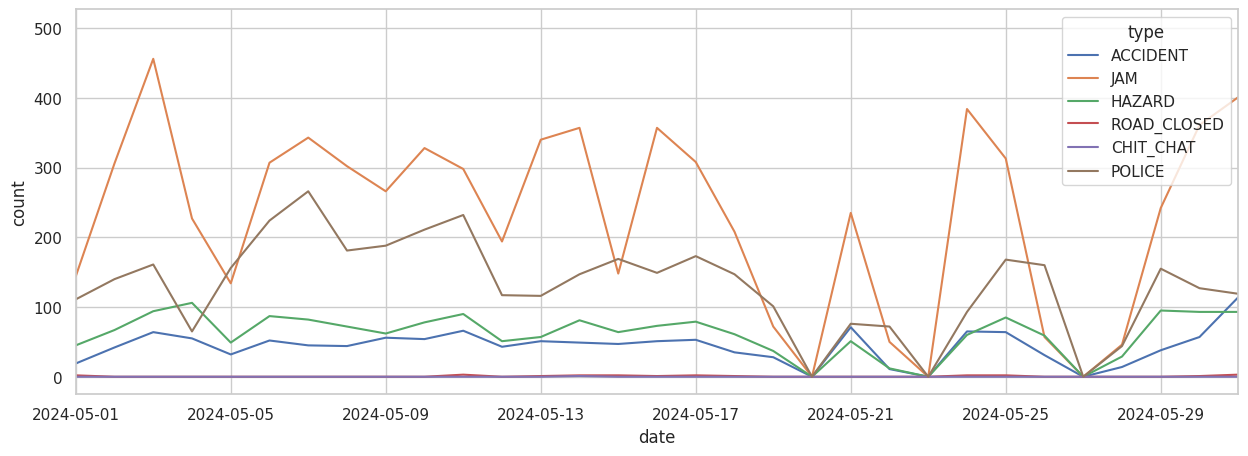

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (15, 5))
# set palette
# palette = sns.color_palette("hsv", len(alertdf_all_by_date['type'].unique()))
sns.lineplot(data = alertdf_all_by_date, 
             x = 'date', 
             y = 'count', 
             hue = 'type', 
             ax = ax)
# set x-limit from 05-01-2024
ax.set_xlim(pd.Timestamp('2024-05-01'), pd.Timestamp('2024-05-31'))

In [22]:
# find coordinates of all alerts
alertdf_all_combined['lat'] = alertdf_all_combined['location'].apply(lambda x: x['y'])
alertdf_all_combined['lon'] = alertdf_all_combined['location'].apply(lambda x: x['x'])


In [31]:
cols_keep = ['country', 'inscale', 'city', 'reportRating',
       'reportByMunicipalityUser', 'confidence', 'reliability', 'type', 'uuid',
       'speed', 'reportMood', 'roadType', 'magvar', 'subtype', 'street',
       'additionalInfo', 
    #    'wazeData',  
       'id', 
    #   'reportBy',
    #    'nearBy', 'imageUrl', 'imageId', 'nImages',
       'date', 'lat', 'lon']
alertdf_all_combined[cols_keep].to_csv(os.path.join(EXPORTFOLDER, 
                                                    "{city_lower}_alerts.csv".format(city_lower = sample_city_lower)), index = False)

In [33]:
alertdf_all_combined.groupby([ 'type','subtype',]).count()

country  inscale  city  \
type        subtype                                                      
ACCIDENT                                           1899     1899   633   
            ACCIDENT_MAJOR                          166      167    57   
            ACCIDENT_MINOR                           22       23     5   
CHIT_CHAT                                             9        9     6   
HAZARD                                                1        1     0   
            HAZARD_ON_ROAD                          539      539   218   
            HAZARD_ON_ROAD_CAR_STOPPED               11       11     1   
            HAZARD_ON_ROAD_CONSTRUCTION             747      747   235   
            HAZARD_ON_ROAD_ICE                        4        4     1   
            HAZARD_ON_ROAD_OBJECT                   191      191    39   
            HAZARD_ON_ROAD_POT_HOLE                  68       68    38   
            HAZARD_ON_ROAD_ROAD_KILL                  1        1     1   
            HAZARD_ON_ROAD_TRAFFIC_LIGHT_FAULT       59       59    42   
            HAZARD_ON_SHOULDER_ANIMALS                1        1     0   
            HAZARD_ON_SHOULDER_CAR_STOPPED         1375     1375   361   
            HAZARD_WEATHER                           70       70    38   
            HAZARD_WEATHER_FLOOD                     24       24     8   
            HAZARD_WEATHER_FOG                       23       23    14   
            HAZARD_WEATHER_HAIL                       1        1     0   
            HAZARD_WEATHER_HEAVY_SNOW                 3        3     2   
JAM                                                4072     4072  1417   
            JAM_HEAVY_TRAFFIC                      4220     4220  1511   
            JAM_MODERATE_TRAFFIC                     27       28     6   
            JAM_STAND_STILL_TRAFFIC                2599     2599  1188   
POLICE                                             5455     5455  1783   
            POLICE_HIDING                           620      621   201   
            POLICE_VISIBLE                           42       42    15   
ROAD_CLOSED                                          24       24    21   
            ROAD_CLOSED_EVENT                        15       15    12   

                                                reportRating  \
type        subtype                                            
ACCIDENT                                                1899   
            ACCIDENT_MAJOR                               167   
            ACCIDENT_MINOR                                23   
CHIT_CHAT                                                  9   
HAZARD                                                     1   
            HAZARD_ON_ROAD                               539   
            HAZARD_ON_ROAD_CAR_STOPPED                    11   
            HAZARD_ON_ROAD_CONSTRUCTION                  747   
            HAZARD_ON_ROAD_ICE                             4   
            HAZARD_ON_ROAD_OBJECT                        191   
            HAZARD_ON_ROAD_POT_HOLE                       68   
            HAZARD_ON_ROAD_ROAD_KILL                       1   
            HAZARD_ON_ROAD_TRAFFIC_LIGHT_FAULT            59   
            HAZARD_ON_SHOULDER_ANIMALS                     1   
            HAZARD_ON_SHOULDER_CAR_STOPPED              1375   
            HAZARD_WEATHER                                70   
            HAZARD_WEATHER_FLOOD                          24   
            HAZARD_WEATHER_FOG                            23   
            HAZARD_WEATHER_HAIL                            1   
            HAZARD_WEATHER_HEAVY_SNOW                      3   
JAM                                                     4072   
            JAM_HEAVY_TRAFFIC                           4220   
            JAM_MODERATE_TRAFFIC                          28   
            JAM_STAND_STILL_TRAFFIC                     2599   
POLICE                                                  5455   
            POLICE_HIDING

# Combine all files together

In [31]:
files = os.listdir(EXPORTFOLDER)
print(len(files))
df = []
for f in tqdm(files):
    if not f.startswith('c_'):
        temp = pd.read_csv(os.path.join(EXPORTFOLDER, f))
        temp['city']  = f.split("_")[0]
        df.append(temp)
df = pd.concat(df).reset_index(drop = True)
df.head()

118


100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


,country,inscale,city,reportRating,reportByMunicipalityUser,confidence,reliability,type,uuid,speed,reportMood,roadType,magvar,subtype,street,additionalInfo,id,date,lat,lon
0,HK,False,hongkong,1,False,0,5,JAM,44c792db-02c7-40ee-8d95-8712ecba98d3,0,46,2.0,265,JAM_STAND_STILL_TRAFFIC,Austin Rd 柯士甸道,NaN,alert-633730904/44c792db-02c7-40ee-8d95-8712ec...,2024-04-27,22.303067,114.169639
1,HK,False,hongkong,0,False,0,5,POLICE,cf3d33fa-d5bf-4578-8825-1182b426ad7e,0,1,1.0,311,POLICE_HIDING,Tung Chi St 童子街,NaN,alert-633720018/cf3d33fa-d5bf-4578-8825-1182b4...,2024-04-27,22.371168,114.138434
2,HK,False,hongkong,5,False,3,10,ROAD_CLOSED,7aa2526c-70e3-4b19-88c4-4a5efd99da10,0,0,1.0,120,ROAD_CLOSED_EVENT,Yiu Hing Rd 耀興道,NaN,alert-1825587095/7aa2526c-70e3-4b19-88c4-4a5ef...,2024-03-22,22.277282,114.223575
3,HK,False,hongkong,2,False,1,7,ACCIDENT,f38a2c92-6a5a-4c26-888f-a53bab903bbe,0,46,2.0,146,NaN,Lei Yue Mun Rd 鯉魚門道,NaN,alert-633188986/f38a2c92-6a5a-4c26-888f-a53bab...,2024-04-27,22.302994,114.236706
4,HK,False,hongkong,0,False,4,10,ACCIDENT,c44c9d4c-24eb-44a1-bf5f-2fbd6ac4a299,0,731,4.0,229,ACCIDENT_MAJOR,"Shap Pat Heung ITC 十八鄉交匯處, Pok Oi ITC 博愛交匯處",NaN,alert-632033925/c44c9d4c-24eb-44a1-bf5f-2fbd6a...,2024-04-27,22.436382,114.036429


In [32]:
ncity = df['city'].nunique()
print("Number of cities: {ncity}".format(ncity = ncity))
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
with_accident = df[df['type']=='ACCIDENT']
ncity_with_accident = with_accident['city'].nunique()
print("Number of cities with accident: {ncity_with_accident}".format(ncity_with_accident = ncity_with_accident))
with_accident_major = with_accident[with_accident['subtype']=='ACCIDENT_MAJOR']
ncity_with_accident_major = with_accident_major['city'].nunique()
print("Number of cities with major accident: {ncity_with_accident_major}".format(ncity_with_accident_major = ncity_with_accident_major))

Number of cities: 103
Number of cities with accident: 103
Number of cities with major accident: 97


In [34]:
df_sel = df[(df['date']>= '2024-04-24')].reset_index(drop = True).drop_duplicates(subset = ['uuid'])
df_sel.shape
print("Number of alerts: {nalerts}".format(nalerts = df_sel.shape[0]))

Number of alerts: 7359480


In [43]:
df_sel[df_sel['confidence']>=2]['city'].nunique()

84

In [41]:
import h3
df_sel['h3_9'] = df_sel.apply(lambda x: h3.geo_to_h3(x['lat'], x['lon'], 9), axis = 1)
df_sel['h3_8'] = df_sel.apply(lambda x: h3.geo_to_h3(x['lat'], x['lon'], 8), axis = 1)

In [44]:
# df_sel['type'].unique()
for t in df_sel['type'].unique():
    print(t)
    temp = df_sel[(df_sel['type']==t)&(df_sel['confidence']>1)].reset_index(drop = True)
    temp.to_csv(os.path.join(EXPORTFOLDER, "c_waze_{t}_alerts.csv".format(t = t.lower())), index = False)
    temph3 = temp.groupby(['city','h3_9'])['id'].nunique().reset_index(name = 'count')
    temph3.to_csv(os.path.join(EXPORTFOLDER, "c_waze_{t}_alerts_h3_9.csv".format(t = t.lower())), index = False)

JAM
POLICE
ACCIDENT
HAZARD
CHIT_CHAT
ROAD_CLOSED


In [47]:
df_sel[(df_sel['subtype']=='ACCIDENT_MAJOR')&(df_sel['confidence']>1)].groupby(['city','h3_9'])['id'].nunique().reset_index(name = 'major_accident_count')\
    .to_csv(os.path.join(EXPORTFOLDER, "c_waze_major_accident_h3_9.csv"), index = False)

In [48]:
df_sel[(df_sel['confidence']>1)].groupby(['city','h3_9'])['id'].nunique().reset_index(name = 'count')\
    .to_csv(os.path.join(EXPORTFOLDER, "c_waze_all_alerts_h3_9.csv"), index = False)

In [49]:
df_sel = pd.read_csv(os.path.join(EXPORTFOLDER, "c_waze_all_alerts_h3_9.csv"))
df_sel['city'].nunique()

84

In [12]:
accident_summary = df_sel[(df_sel['type']=='ACCIDENT')]\
    .groupby(['city'])['id'].nunique().reset_index().sort_values('id', ascending = False).reset_index()
accident_summary.head(60)

,index,city,id
0,28,lima,1039
1,5,bogotá,951
2,26,kualalumpur,756
3,48,riodejaneiro,685
4,52,saopaulo,533
5,3,belohorizonte,527
6,42,paris,518
7,19,guadalajara,515
8,41,newyork,512
9,31,madrid,498


In [13]:
accident_summary.to_csv(os.path.join(EXPORTFOLDER, "c_accident_all_city.csv"), index = False)

In [28]:
accident_summary = pd.read_csv(os.path.join(EXPORTFOLDER, "c_accident_all_city.csv"))
accident_summary['city'].nunique()

62

In [6]:
# calculate the total road length per city per study area
sample_city_lower = "boston"
roadpath = "/group/geog_pyloo/08_GSV/data/gsv_rgb/{citylower}/road/osm.geojson".format(citylower = sample_city_lower)
# boundpath = 
road = gpd.read_file(roadpath)
# airesearch['length'] = airesearch['geometry'].length

KeyboardInterrupt: 